# Clustering Analysis

Investigate whether semantic clustering can reduce the number of questions needing API categorization.

**Hypothesis:** Semantically similar questions can be grouped, with one canonical question per cluster sent to the API.

**Goal:** Determine if clustering provides meaningful cost savings or if direct categorization is more appropriate.

In [18]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Embeddings

In [19]:
print("Loading embeddings...")

embeddings_path = Path('../data/processed/embeddings/embeddings_with_metadata.pkl')
with open(embeddings_path, 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings']
question_ids = data['question_ids']
question_texts = data['question_texts']

print(f"Loaded {len(embeddings):,} embeddings")
print(f"Embedding dimension: {embeddings.shape[1]}")

Loading embeddings...
Loaded 6,295 embeddings
Embedding dimension: 1024


## Embedding Statistics

In [20]:
# Basic embedding statistics
print("\nEmbedding statistics:")
print(f"Mean per dimension: {embeddings.mean(axis=0).mean():.4f}")
print(f"Std per dimension: {embeddings.std(axis=0).mean():.4f}")
print(f"Min: {embeddings.min():.4f}")
print(f"Max: {embeddings.max():.4f}")

# Variance across questions
per_dim_variance = embeddings.var(axis=0)
print(f"\nVariance across questions:")
print(f"Mean variance: {per_dim_variance.mean():.6f}")
print(f"Min variance: {per_dim_variance.min():.6f}")
print(f"Max variance: {per_dim_variance.max():.6f}")


Embedding statistics:
Mean per dimension: -0.0316
Std per dimension: 0.0863
Min: -31.3662
Max: 2.3050

Variance across questions:
Mean variance: 0.007817
Min variance: 0.004036
Max variance: 0.167639


## Compute Similarity Matrix

In [21]:
print("\nComputing cosine similarity matrix...")
print("This may take a few minutes...\n")

similarity_matrix = cosine_similarity(embeddings)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Memory size: {similarity_matrix.nbytes / 1024 / 1024:.1f} MB")


Computing cosine similarity matrix...
This may take a few minutes...

Similarity matrix shape: (6295, 6295)
Memory size: 151.2 MB


## Similarity Distribution

In [22]:
# Exclude diagonal (self-similarity = 1.0)
mask = np.ones(similarity_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)
off_diagonal_sims = similarity_matrix[mask]

print("="*70)
print("PAIRWISE SIMILARITY STATISTICS")
print("="*70)
print(f"Mean:   {off_diagonal_sims.mean():.6f}")
print(f"Median: {np.median(off_diagonal_sims):.6f}")
print(f"Std:    {off_diagonal_sims.std():.6f}")
print(f"Min:    {off_diagonal_sims.min():.6f}")
print(f"Max:    {off_diagonal_sims.max():.6f}")
print(f"Range:  {off_diagonal_sims.max() - off_diagonal_sims.min():.6f}")
print("="*70)

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(off_diagonal_sims, p)
    print(f"  {p:2d}th: {val:.6f}")

PAIRWISE SIMILARITY STATISTICS
Mean:   0.991614
Median: 0.991924
Std:    0.002322
Min:    0.965499
Max:    0.999994
Range:  0.034494

Percentiles:
   1th: 0.984635
   5th: 0.987376
  10th: 0.988604
  25th: 0.990349
  50th: 0.991924
  75th: 0.993219
  90th: 0.994212
  95th: 0.994763
  99th: 0.995865


## Visualize Distribution

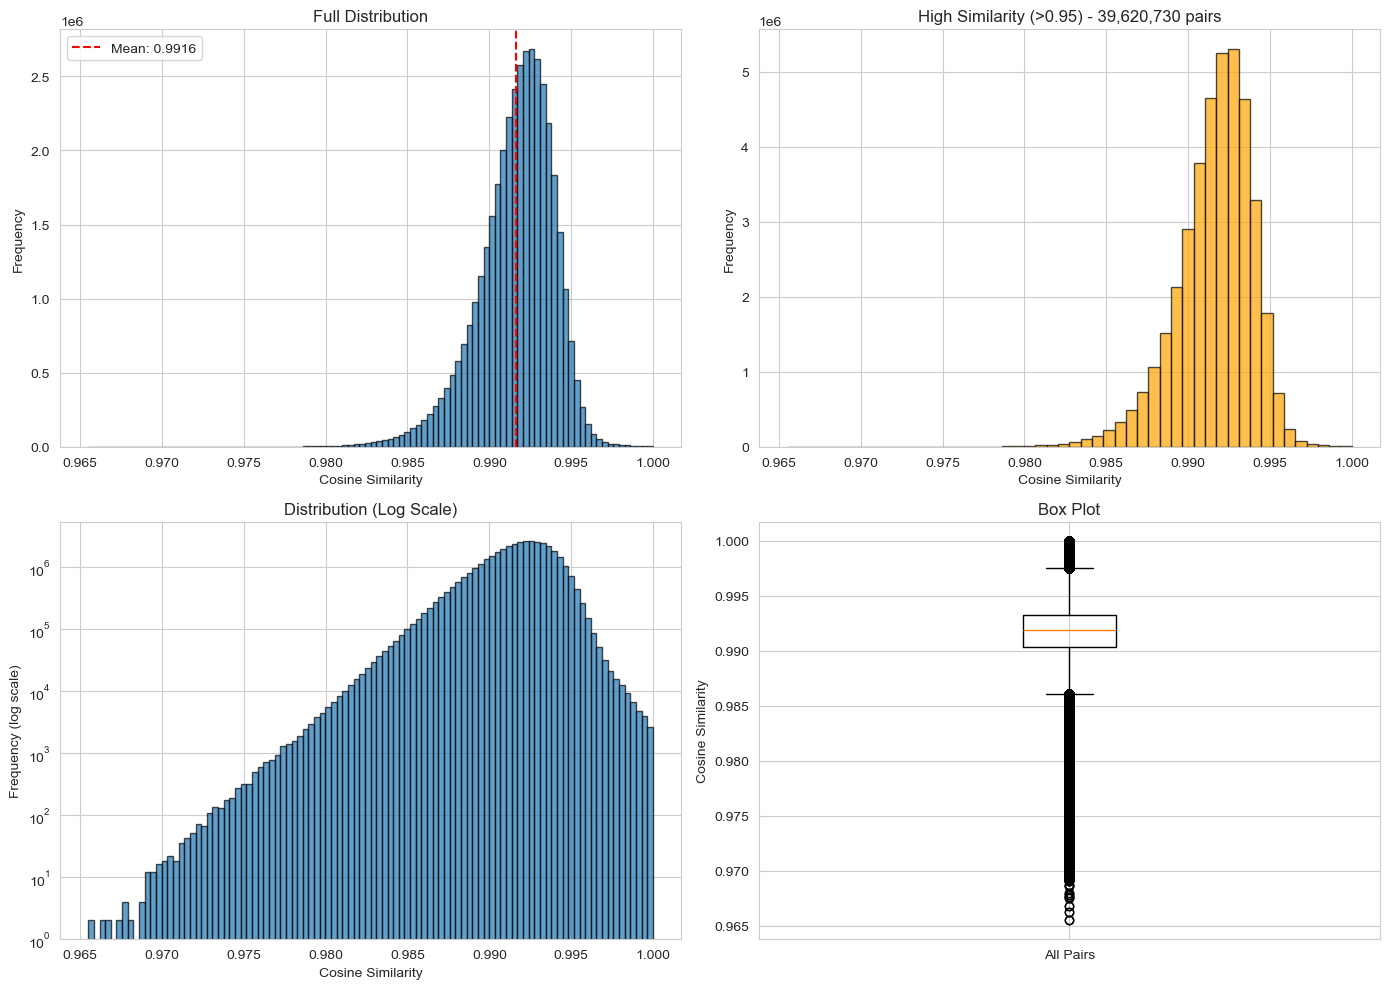

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Full distribution
axes[0, 0].hist(off_diagonal_sims, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Full Distribution')
axes[0, 0].axvline(off_diagonal_sims.mean(), color='red', linestyle='--', 
                   label=f'Mean: {off_diagonal_sims.mean():.4f}')
axes[0, 0].legend()

# Zoomed to high range
high_range = off_diagonal_sims[off_diagonal_sims > 0.95]
axes[0, 1].hist(high_range, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Cosine Similarity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'High Similarity (>0.95) - {len(high_range):,} pairs')

# Log scale
axes[1, 0].hist(off_diagonal_sims, bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Distribution (Log Scale)')

# Box plot
axes[1, 1].boxplot(off_diagonal_sims, vert=True)
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].set_title('Box Plot')
axes[1, 1].set_xticklabels(['All Pairs'])

plt.tight_layout()
plt.show()

## Data-Driven Thresholds

In [24]:
# Calculate thresholds based on actual data distribution
mean_sim = off_diagonal_sims.mean()
std_sim = off_diagonal_sims.std()

# Thresholds based on standard deviations and percentiles
thresholds = [
    mean_sim + 3*std_sim,
    mean_sim + 2*std_sim,
    mean_sim + std_sim,
    np.percentile(off_diagonal_sims, 99),
    np.percentile(off_diagonal_sims, 95),
    np.percentile(off_diagonal_sims, 90),
    mean_sim,
]

# Remove invalid (>1.0) and duplicates
thresholds = sorted(list(set([t for t in thresholds if t <= 1.0])), reverse=True)

print("\nData-driven thresholds:")
print("="*70)
for i, threshold in enumerate(thresholds, 1):
    count = (off_diagonal_sims >= threshold).sum()
    pct = (count / len(off_diagonal_sims)) * 100
    print(f"{i}. {threshold:.6f}: {count:,} pairs ({pct:.4f}%)")
print("="*70)


Data-driven thresholds:
1. 0.998580: 18,962 pairs (0.0479%)
2. 0.996258: 230,920 pairs (0.5828%)
3. 0.995865: 396,218 pairs (1.0000%)
4. 0.994763: 1,981,158 pairs (5.0003%)
5. 0.994212: 3,962,302 pairs (10.0006%)
6. 0.993936: 5,325,598 pairs (13.4414%)
7. 0.991614: 22,079,632 pairs (55.7275%)


## Most Similar Question Pairs

In [25]:
# Find most similar pairs
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
upper_tri_sims = similarity_matrix[upper_tri_indices]

top_n = 20
top_indices = np.argsort(upper_tri_sims)[-top_n:][::-1]

print(f"\nTop {top_n} Most Similar Question Pairs:")
print("="*70)

for rank, idx in enumerate(top_indices, 1):
    i = upper_tri_indices[0][idx]
    j = upper_tri_indices[1][idx]
    sim = similarity_matrix[i, j]
    
    print(f"\n{rank}. Similarity: {sim:.6f}")
    print(f"   Q1: {question_texts[i][:100]}...")
    print(f"   Q2: {question_texts[j][:100]}...")


Top 20 Most Similar Question Pairs:

1. Similarity: 0.999994
   Q1: (The next few questions are about assets and other investments, either individually or jointly owned...
   Q2: (The next few questions are about assets and other investments, either individually or jointly owned...

2. Similarity: 0.999988
   Q1: DURING THE PAST 12 MONTHS, how often did this child’s doctors or other health care providers... a. S...
   Q2: DURING THE PAST 12 MONTHS, how often did this child's doctors or other health care providers... a. S...

3. Similarity: 0.999987
   Q1: ^C_BTWN_TO12_EMONTH there any more time periods when ^TEMPNAME ^WASWERE looking for work?...
   Q2: ^C_BTWN_TO13_EMONTH there any more time periods when ^TEMPNAME ^WASWERE looking for work?...

4. Similarity: 0.999985
   Q1: (I have some questions about the place where ^TEMPNAME ^WEREWAS living in ^REFYEAR. Were the followi...
   Q2: (I have some questions about the place where ^TEMPNAME ^WEREWAS living in ^REFYEAR. Were the followi.

## Clustering at Different Thresholds

In [26]:
print("\n" + "="*70)
print("CLUSTERING RESULTS")
print("="*70)
print(f"\nTotal questions: {len(embeddings):,}\n")

clustering_results = []

# Test top 5 thresholds
for threshold in thresholds[:5]:
    distance_matrix = 1 - similarity_matrix
    
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=1 - threshold,
        metric='precomputed',
        linkage='average'
    )
    
    labels = clustering.fit_predict(distance_matrix)
    num_clusters = len(set(labels))
    
    cluster_sizes = Counter(labels)
    singletons = sum(1 for size in cluster_sizes.values() if size == 1)
    
    reduction = len(embeddings) - num_clusters
    pct_reduction = (reduction / len(embeddings)) * 100
    
    clustering_results.append({
        'threshold': threshold,
        'num_clusters': num_clusters,
        'singletons': singletons,
        'reduction': reduction,
        'pct_reduction': pct_reduction
    })
    
    print(f"Threshold: {threshold:.6f}")
    print(f"  Clusters: {num_clusters:,}")
    print(f"  Singletons: {singletons:,}")
    print(f"  Reduction: {reduction:,} questions ({pct_reduction:.2f}%)")
    print()


CLUSTERING RESULTS

Total questions: 6,295

Threshold: 0.998580
  Clusters: 4,492
  Singletons: 3,563
  Reduction: 1,803 questions (28.64%)

Threshold: 0.996258
  Clusters: 2,045
  Singletons: 969
  Reduction: 4,250 questions (67.51%)

Threshold: 0.995865
  Clusters: 1,705
  Singletons: 724
  Reduction: 4,590 questions (72.92%)

Threshold: 0.994763
  Clusters: 934
  Singletons: 340
  Reduction: 5,361 questions (85.16%)

Threshold: 0.994212
  Clusters: 650
  Singletons: 218
  Reduction: 5,645 questions (89.67%)



## Cost Analysis

In [27]:
# Cost calculation (GPT-4o-mini pricing)
INPUT_TOKENS_PER_Q = 300
OUTPUT_TOKENS_PER_Q = 200
INPUT_COST_PER_1M = 0.15
OUTPUT_COST_PER_1M = 0.60

def calculate_cost(num_questions):
    input_cost = (num_questions * INPUT_TOKENS_PER_Q / 1_000_000) * INPUT_COST_PER_1M
    output_cost = (num_questions * OUTPUT_TOKENS_PER_Q / 1_000_000) * OUTPUT_COST_PER_1M
    return input_cost + output_cost

base_cost = calculate_cost(len(embeddings))

print("\n" + "="*70)
print("COST ANALYSIS (GPT-4o-mini)")
print("="*70)
print(f"\nBase cost (all {len(embeddings):,} questions): ${base_cost:.2f}")
print("\nCosts with clustering:\n")

for result in clustering_results:
    clustered_cost = calculate_cost(result['num_clusters'])
    savings = base_cost - clustered_cost
    
    print(f"Threshold {result['threshold']:.6f}:")
    print(f"  Cost: ${clustered_cost:.2f}")
    print(f"  Savings: ${savings:.2f}")
    print()


COST ANALYSIS (GPT-4o-mini)

Base cost (all 6,295 questions): $1.04

Costs with clustering:

Threshold 0.998580:
  Cost: $0.74
  Savings: $0.30

Threshold 0.996258:
  Cost: $0.34
  Savings: $0.70

Threshold 0.995865:
  Cost: $0.28
  Savings: $0.76

Threshold 0.994763:
  Cost: $0.15
  Savings: $0.88

Threshold 0.994212:
  Cost: $0.11
  Savings: $0.93



## Summary

In [28]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\nCorpus characteristics:")
print(f"  Total questions: {len(embeddings):,}")
print(f"  Mean similarity: {mean_sim:.6f}")
print(f"  Std deviation: {std_sim:.6f}")
print(f"  Coefficient of variation: {std_sim/mean_sim:.6f}")
print(f"  Range: {off_diagonal_sims.max() - off_diagonal_sims.min():.6f}")

# Best result
best_result = clustering_results[0]
print(f"\nBest clustering result:")
print(f"  Threshold: {best_result['threshold']:.6f}")
print(f"  Clusters: {best_result['num_clusters']:,}")
print(f"  Reduction: {best_result['reduction']:,} ({best_result['pct_reduction']:.2f}%)")
print(f"  Cost: ${calculate_cost(best_result['num_clusters']):.2f}")
print(f"  Savings: ${base_cost - calculate_cost(best_result['num_clusters']):.2f}")

print("\n" + "="*70)


SUMMARY

Corpus characteristics:
  Total questions: 6,295
  Mean similarity: 0.991614
  Std deviation: 0.002322
  Coefficient of variation: 0.002342
  Range: 0.034494

Best clustering result:
  Threshold: 0.998580
  Clusters: 4,492
  Reduction: 1,803 (28.64%)
  Cost: $0.74
  Savings: $0.30



## Guidance for Next Steps

In [29]:
print("\n" + "="*70)
print("INPUTS FOR NOTEBOOK 04: RoBERTa CONCEPT MATCHING")
print("="*70)

print("\n1. Question embeddings:")
print(f"   - {len(embeddings):,} questions embedded with RoBERTa-large")
print(f"   - Embedding dimension: {embeddings.shape[1]}")
print(f"   - Location: {embeddings_path}")

print("\n2. Observed similarity characteristics:")
print(f"   - Mean pairwise similarity: {mean_sim:.6f}")
print(f"   - Std deviation: {std_sim:.6f}")

print("\n3. Recommended workflow:")
print("   a. Load Census taxonomy: ../data/raw/census_survey_explorer_taxonomy.json")
print("   b. Embed Census concept definitions (5 topics + 152 subtopics)")
print("   c. Compute question → concept similarities")
print("   d. Assign top-k concepts per question (suggest k=5)")
print("   e. Save for comparison with GPT categorization")

print("\n4. Note:")
print("   - Use top-k ranking rather than absolute similarity thresholds")
print("   - Federal survey domain shows high baseline similarity")

print("\n" + "="*70)


INPUTS FOR NOTEBOOK 04: RoBERTa CONCEPT MATCHING

1. Question embeddings:
   - 6,295 questions embedded with RoBERTa-large
   - Embedding dimension: 1024
   - Location: ../data/processed/embeddings/embeddings_with_metadata.pkl

2. Observed similarity characteristics:
   - Mean pairwise similarity: 0.991614
   - Std deviation: 0.002322

3. Recommended workflow:
   a. Load Census taxonomy: ../data/raw/census_survey_explorer_taxonomy.json
   b. Embed Census concept definitions (5 topics + 152 subtopics)
   c. Compute question → concept similarities
   d. Assign top-k concepts per question (suggest k=5)
   e. Save for comparison with GPT categorization

4. Note:
   - Use top-k ranking rather than absolute similarity thresholds
   - Federal survey domain shows high baseline similarity



# Clustering Analysis Conclusions

## The Numbers

- **Mean pairwise similarity: 0.9916**
- **Standard deviation: 0.0023**
- **Range: 0.9655 to 0.999994 (3.45% total spread)**

The entire corpus sits in a 3.45% similarity band. Even the "most dissimilar" questions are 96.5% similar.

## What Are We Actually Looking At?

Let's examine question pairs at different similarity levels to understand what these numbers mean:

**At 99th percentile (0.9959):**
```
Q1: "How much did ^TEMPNAME receive before ^AMT2_STARTFIL? What would you estimate the monthly amount to be?"
Q2: "How much did ^TEMPNAME receive before ^AMT3_STARTFIL? What would you estimate the monthly amount to be?"
```
These are the same question with a variable substitution (AMT2 vs AMT3).

**At 75th percentile (0.9932):**
```
Q1: "At any time DURING THE PAST 12 MONTHS, even for one month, did anyone in your family receive... a. Cash assistance from a state or county welfare program..."
Q2: "At any time DURING THE PAST 12 MONTHS, even for one month, did anyone in your family receive... b. Food Stamps or Food Stamp benefits..."
```
Same question structure, different program being asked about.

**At median (0.9919):**
```
Q1: "Does this child currently have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or government plans such as Medicaid?"
Q2: "During the past 12 months, was there any time when this child did not have any health insurance coverage?"
```
Both health insurance questions, but asking fundamentally different things (current coverage vs gaps).

**At 25th percentile (0.9903):**
```
Q1: "What is your main reason for working part-time rather than full-time?"
Q2: "What was the total amount of gross income or loss from this business in 2019, before deducting expenses?"
```
Completely different questions - one about work preferences, one about business income. Still 99% similar.

## Why Clustering Fails Here

At 0.9942 similarity (90th percentile threshold):
- Reduces to 650 clusters (90% reduction)
- Saves $0.93 on ~$1 total cost
- But groups questions that are asking about completely different concepts

The corpus is so semantically homogeneous that similarity thresholds can't distinguish between:
1. Actual duplicates (variable substitutions)
2. Questions about the same topic with different specifics
3. Questions about completely different topics that use similar formal survey language

## The Real Problem

We spent hours analyzing clustering approaches to save **93 cents**. The actual API cost for categorizing all 6,295 questions is ~$1.04. 

This is penny-wise and pound-foolish. The risk of conflating distinct questions far outweighs any cost savings.

## Decision

**Skip clustering entirely.** 

Proceed directly to concept-matching. The semantic similarity approach is sound—RoBERTa accurately captures that federal surveys use highly standardized language. But that same standardization means we can't use similarity thresholds to reduce the question set without losing critical distinctions.

The clustering analysis was valuable for understanding the data, but the answer is clear: the $1 cost is negligible, and the quality risk from clustering is unacceptable.